In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
epsilon = 1e-8

EM推导完之后的形式还是比较简单的，现以GMM为例

$$p(x) = \sum_{k=1}^K \pi_k \cdot \mathcal{N}(x\mid \mu_k, \Sigma_k)$$

E-step求出现有观测数据下每个观测数据隐变量的最优的分布函数
$$
\begin{split}
Q_i(k) & = Q(z_i) \\
    & = p(k\mid X, \pi^{old}, \mu^{old}, \Sigma^{old}) \\
    & = p(z_i \mid X, x_i, \theta^{old}) \\
    & = \frac{p(x_i, z_i \mid \theta^{old})}{p(x_i \mid \theta^{old})} \\
    & = \frac{p(x_i, z_i \mid \theta^{old})}{\sum_{k=1}^K p(x_i, z_i \mid \theta^{old})} \\
    & = \frac{\pi_{z_i}\cdot \mathcal{N}(x_i\mid \mu_{z_i}, \Sigma_{z_i})}{\sum_{z_i}\pi_{z_i}\cdot \mathcal{N}(x_i\mid \mu_{z_i}, \Sigma_{z_i})} \\
    & = \frac{\pi_k^{old} \cdot \mathcal{N}(x_i\mid \mu_k^{old}, \Sigma_k^{old})}{\sum_l^K \pi_l^{old} \cdot \mathcal{N}(x_i\mid \mu_l^{old}, \Sigma_l^{old})}
\end{split}
$$

M-step在上面求得每一个观测数据的$Q_i(k)$的情况下，求当前最优的参数
$$
\pi_k = \frac{1}{N}\sum_i^N Q_i(k) \\
\mu_k = \frac{\sum_i^N Q_i(k)x_i}{\sum_i^N Q_i(k)} \\
\Sigma_k = \frac{\sum_i^N Q_i(k)(x_i-\mu_k)(x_i-\mu_k)^T}{\sum_i^N Q_i(k)} \\
$$

最后不断迭代上述过程即可

In [2]:
from sklearn.datasets import make_blobs

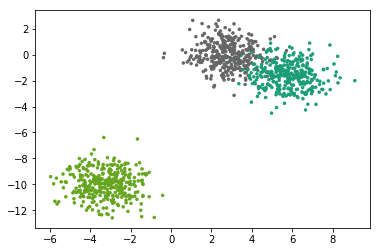

In [15]:
## 生成数据
X, Y = make_blobs(n_samples=1000,n_features=2, centers=3)
plt.scatter(X[:, 0], X[:, 1], marker='.', c=Y, s=25, cmap='Dark2')

In [16]:
class GMM(object):
    def __init__(self, K, max_iter=500, eps=1e-5):
        self.K = K
        self.max_iter = max_iter
        self.eps = eps
    def gaussian(self, X, mu, sigma):
        return 1. / (np.power(2*np.pi, self.D/2.) 
                     * np.sqrt(np.linalg.det(sigma))) * np.exp(-0.5 * np.sum(np.dot(X - mu, np.linalg.pinv(sigma)) 
                                                                             * (X - mu), axis=1))
    def E_step(self):
        self.Q = self.pdf * self.Pi
        self.Q = self.Q / np.sum(self.Q, axis=1, keepdims=True)
    
    def M_step(self):
        for k in range(self.K):
            t = np.sum(self.Q[:, k])
            self.Pi[k] = t / self.N
            self.Mu[k] = np.sum(self.X * self.Q[:, k][:, np.newaxis], axis=0) / t
            self.Sigma[k] = np.dot((self.Q[:, k][:, np.newaxis] * (self.X - self.Mu[k])).T, self.X - self.Mu[k]) / t
    
    def log_likehood(self):
        return np.sum(np.log(np.sum(self.pdf * self.Pi, axis=1)))
    
    def fit(self, X):
        self.X = X
        self.N, self.D = X.shape
        self.Q = np.zeros((self.N, self.K))
        self.Pi = np.zeros(self.K) + 1./self.K
        self.Mu = np.random.permutation(self.X)[:self.K]  ## 随机选择K个当作初始均值
        self.Sigma = np.concatenate([np.cov(self.X.T)[np.newaxis,:] for _ in range(self.K)])
        self.pdf = np.zeros((self.N, self.K))
        old_loglikehood = np.inf
        for _iter in range(self.max_iter):
            for k in range(self.K):
                self.pdf[:, k] = self.gaussian(self.X, self.Mu[k], self.Sigma[k])
            self.E_step()
            self.M_step()
            new_llh = self.log_likehood()
            if np.abs(old_loglikehood - new_llh) < self.eps:
                print('End with Eps at iter %d' % _iter)
                return
            old_loglikehood = new_llh
        print('End with max iter %d' % self.max_iter)
    
    def p(self, x):
        if x.ndim < 2:
            x = x[np.newaxis, :]
        N = x.shape[0]
        t = np.zeros((N, self.K))
        for k in range(self.K):
            t[:, k] = self.Pi[k] * self.gaussian(x, self.Mu[k], self.Sigma[k])
        return np.sum(t, axis=1)
    
    def predict(self, x):
        if x.ndim < 2:
            x = x[np.newaxis, :]
        N = x.shape[0]
        t = np.zeros((N, self.K))
        for k in range(self.K):
            t[:, k] = self.Pi[k] * self.gaussian(x, self.Mu[k], self.Sigma[k])
        return np.argmax(t, axis=1), t / np.sum(t, axis=1)

In [17]:
gmm = GMM(K=3)
gmm.fit(X)

End with Eps at iter 75


In [18]:
def plot_decision_boundary(model, resolution=100, colors=('b', 'k', 'r'), figsize=(14,6)):
    plt.figure(figsize=figsize)
    
    xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
    yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
    grid = [[model.p(np.array([xr, yr])) for yr in yrange] for xr in xrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))
    
    plt.scatter(model.X[:, 0], model.X[:, 1], marker='.', c=Y-1, s=25, cmap='Dark2')
    plt.contour(xrange, yrange, grid.T, linewidths=(1,),
               linestyles=('-',), colors=colors[1])

In [19]:
gmm.Y = Y

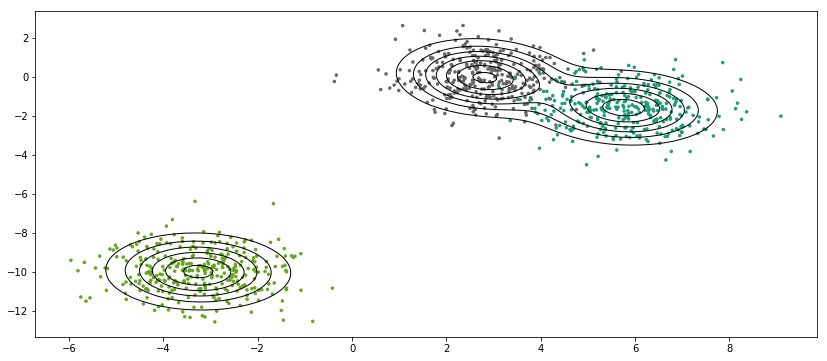

In [20]:
plot_decision_boundary(gmm)

In [21]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler

In [22]:
X, Y = make_moons(n_samples=500, shuffle=True, noise=0.1)

In [23]:
gmm = GMM(K=2)
gmm.fit(X)

End with Eps at iter 116


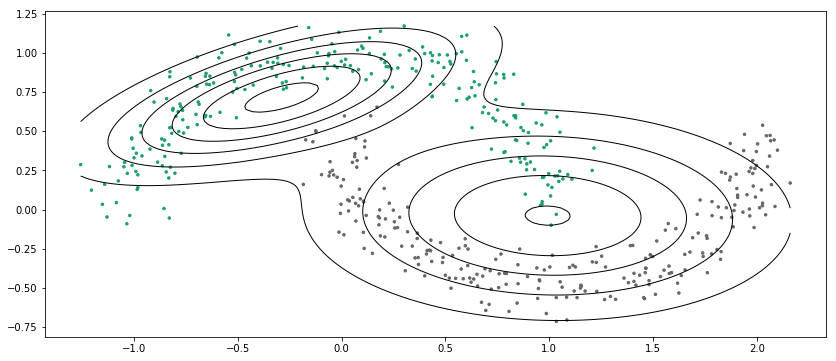

In [24]:
gmm.Y = Y
plot_decision_boundary(gmm)